## HW02 Code

### Name: Your name here

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.)


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2020/comp135/home).

In [21]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from statistics import mean
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [22]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [23]:
data = pd.read_csv('data.csv')

In [36]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [37]:
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list, error_list = list(), list()
    for degree in polynomials:
        poly   = PolynomialFeatures(degree=degree)
        xP     = poly.fit_transform(x)
        linReg = linear_model.LinearRegression()
        linReg.fit(xP, y) # not perfect, so predict after
        yP = linReg.predict(xP)
        prediction_list.append(yP)
        error_list.append(mean_squared_error(y, yP))
    return prediction_list, error_list

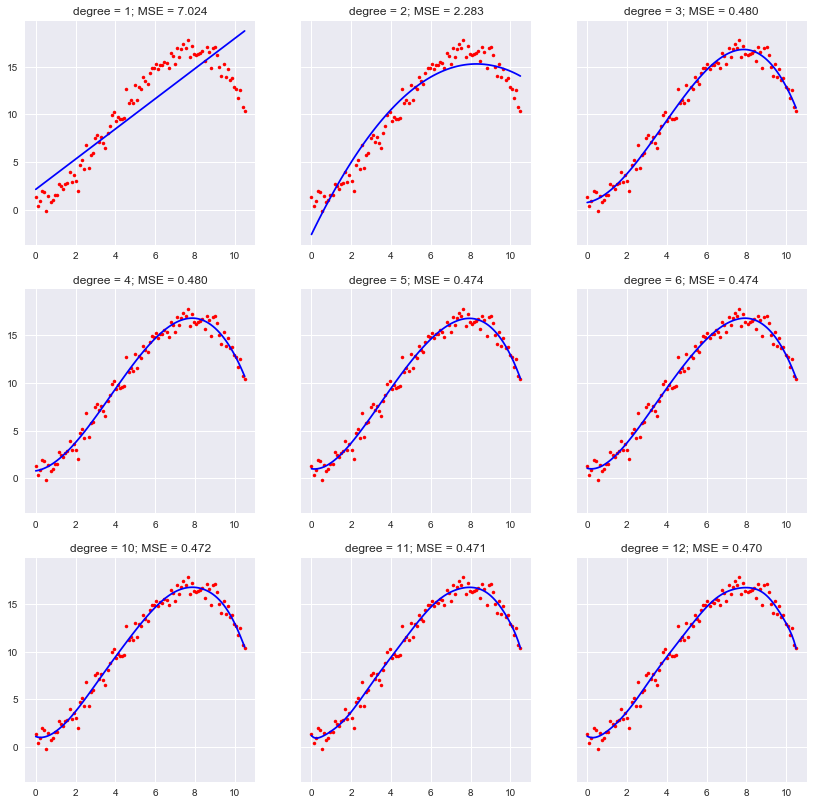

In [38]:
degrees = [1, 2, 3, 4, 5, 6, 10, 11, 12]
p, e = test_polynomials(degrees)
plot_predictions(degrees, p, e)

#### 1.2 Discuss the results seen in the plots above

**Discussion**:  Based solely on the MSE values, we see that the MSE trends downwards as the degree increases, making degree 12 with MSE 0.470 the "best". Of course we recognize that low training MSE does **not** imply low testing MSE, and that this is likely a case of overfitting.

Nevertheless, these results tell us that the relationship between x and y (inputs and outputs) cannot be well approximated by a simple linear function, as evidenced by the fact that the degree 1 and 2 models have a significantly higher MSE than the rest of the models - they are clear outliers. 

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### 2.1 Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.

In [48]:
def make_folds(num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x-data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    size = len(x)
    fold_size = size // num_folds # floor division
    x_fold, y_fold = [], []
    for i in range(0, size, fold_size):
        x_fold.append(x[i: i + fold_size])
        y_fold.append(y[i: i + fold_size])
    return x_fold, y_fold

In [49]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.  Its output will be used to check your work.
k = 5
x_folds, y_folds = make_folds(k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.2 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

In [50]:
def get_data(x, y, i):
    xtrain = np.delete(np.array(x), i, 0).flatten().reshape(-1,1)
    xtest  = x[i]
    ytrain = np.delete(np.array(y), i, 0).flatten()
    ytest  = y[i]
    return xtrain, xtest, ytrain, ytest

In [51]:
def k_fold_cross_validation(x_folds, y_folds, polynomials=list()):
    trainMSE, testMSE = [[] for i in range(len(polynomials))], [[] for i in range(len(polynomials))]
    num_folds = len(x_folds)
    for d, degree in enumerate(polynomials):
        for i in range(num_folds):
            poly     = PolynomialFeatures(degree=degree)
            x80, x20, y80, y20 = get_data(x_folds.copy(), y_folds.copy(), i)
            xTrain = poly.fit_transform(x80)
            xTest  = poly.fit_transform(x20)
            linReg = linear_model.LinearRegression()
            linReg.fit(xTrain, y80)
            yTrainPredict = linReg.predict(xTrain)
            yTestPredict  = linReg.predict(xTest)
            trainMSE[d].append(mean_squared_error(y80, yTrainPredict))
            testMSE[d].append(mean_squared_error(y20, yTestPredict))	
        trainMSE[d] = mean(trainMSE[d])
        testMSE[d]  = mean(testMSE[d])

    print(('-'*20) + "TRAIN" + ('-'*20) + "\n")
    print(trainMSE)
    print(('-'*20) + "TEST" + ('-'*20) + "\n")
    print(testMSE)
    plt.plot(polynomials, trainMSE, color='blue', label="Training")
    plt.plot(polynomials, testMSE, color='red', label="Testing")
    plt.legend()
    plt.title('Average Training and Testing Error for Linear Regression')
    plt.xlabel('Degree')
    plt.ylabel('Error')
    plt.show()
    return

--------------------TRAIN--------------------

[6.977640618384499, 2.2459200784027114, 0.47162055974893247, 0.4699092227255776, 0.46366318060546896, 0.46206862640077795, 0.4571990531640448, 0.45329384158910246, 0.4518911714536871]
--------------------TEST--------------------

[7.4411565127256125, 2.6256081547919794, 0.558082843725359, 0.5746231833029756, 0.5745796271742222, 0.5866062520163284, 0.6247475129172017, 0.6549481924049221, 0.6625005635915766]


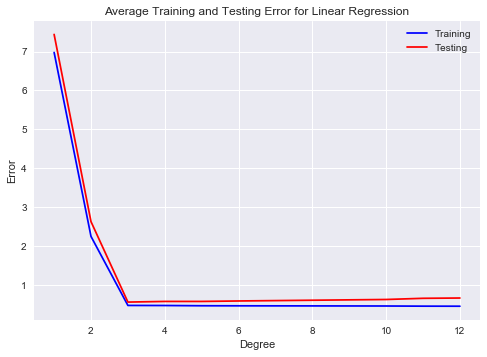

In [52]:
x_folds, y_folds = make_folds(5)
k_fold_cross_validation(x_folds, y_folds, degrees)

#### 2.3 Discuss the results seen in the plots above

**Discussion:** The plotted results show us that, as we observed in Section 1.2, the model performs worst for degree 1 and 2 polynomials, as evidenced by the massively high MSE values in both training and testing in the graph above. This matches our prediction that a simple linear model could not approximate the data accurately. Since a higher degree (and therefore more flexible) linear model performed better - MSE at degree 3 is lower than at degrees 1 and 2 - we can say that underfitting occured for models with degrees 1 and 2. Likewise, for all degrees greater than 3, a lower degree (and therefore less flexible) linear model performed better, and thus we can say that overfitting occured for all models with degrees larger than 3.

Based on the test MSE (red), we see that the degree 3 model performs the best, with an MSE of only 0.558082843725359, a global minimum for the testing error.

### 3. Higher-order polynomials

Results are generated and plotted (as for part 1), for the higher polynomial degrees $d = \{15, 17, 19, 21, 25, 30, 35, 40, 50\}$.

#### 3.1 Plot a grid of prediction results/errors for the higher-order polynomials

--------------------TRAIN--------------------

[0.4526432143706832, 0.5274061007833764, 1.4449703611424491, 2.228260202993064, 6.650958657692537, 10.193107968988578, 17.101946828577823, 19.104162691210455, 22.58492809873637]
--------------------TEST--------------------

[0.6754620736289507, 1.1010091677117795, 1.7654737884924243, 3.1995946767317727, 14.568264993466794, 31.29736251281184, 51.37680350133943, 90.5270116855904, 444.62173660918177]


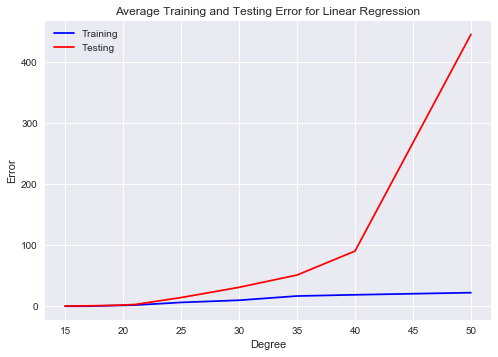

In [53]:
big_degrees = [15, 17, 19, 21, 25, 30, 35, 40, 50]
k_fold_cross_validation(x_folds, y_folds, big_degrees)

#### 3.2 Discuss the results seen in the plots above

**Discussion**: The results in the plots above show that both the training and testing errors increase as degree increases. Although this may be possible for the training data, we know that the higher the degree, the more overfit our model will be for our testing data, and therefore the lower our training MSE **must** be. The fact that even the training MSE increases is alarming. 
We conclude that sk-learn's LinearRegression does not function properly above degree 15, and a bit of research on the topic confirms this suspicion.

### 4. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 4.1 Cross-validation for each regularization strength value

In [56]:
def ridge_regression(x_folds, y_folds, optimal_degree):
    alphas = np.logspace(-2, 2, base=10, num=50) # generates alphas
    alphaTrain, alphaTest = [[] for i in range(len(alphas))], [[] for i in range(len(alphas))]
    num_folds = len(x_folds)
    for a, alpha in enumerate(alphas):
        for i in range(num_folds):
            poly = PolynomialFeatures(degree=optimal_degree)
            xtrain, xtest, ytrain, ytest = get_data(x_folds.copy(), y_folds.copy(), i)
            xTrain   = poly.fit_transform(xtrain)
            xTest    = poly.fit_transform(xtest)
            ridgeReg = linear_model.Ridge(alpha=alpha)
            ridgeReg.fit(xTrain, ytrain)
            yTrainPredict  = ridgeReg.predict(xTrain)
            yTestPredict   = ridgeReg.predict(xTest)
            alphaTrain[a].append(mean_squared_error(ytrain, yTrainPredict))
            alphaTest[a].append(mean_squared_error(ytest, yTestPredict))
        alphaTrain[a] = mean(alphaTrain[a])
        alphaTest[a]  = mean(alphaTest[a])

    print(('-'*20) + "TRAIN" + ('-'*20) + "\n")
    print(alphaTrain)
    print(('-'*20) + "TEST" + ('-'*20) + "\n")
    print(alphaTest)
    plt.plot(alphas, alphaTrain, color='blue', label="Training")
    plt.plot(alphas, alphaTest, color='red', label="Testing")
    plt.legend()
    plt.title('Average Training and Testing Error for Ridge Regression')
    plt.xlabel('Regularization Strength')
    plt.ylabel('Error')
    plt.xscale('log')
    plt.show()
    return

--------------------TRAIN--------------------

[0.47162057509157007, 0.4716205820802388, 0.4716205922484111, 0.47162060703967573, 0.47162062855084613, 0.47162065982587775, 0.4716207052807878, 0.4716207713170239, 0.4716208672052181, 0.4716210063556841, 0.47162120813995057, 0.471621500493764, 0.47162192362203254, 0.4716225352467144, 0.4716234179965318, 0.4716246897380651, 0.4716265178924789, 0.4716291390622093, 0.4716328855804912, 0.4716382208349565, 0.47164578529702783, 0.47165645493431013, 0.4716714128315977, 0.4716922330537886, 0.47172097267555874, 0.47176026320431685, 0.4718133864172189, 0.4718843127415967, 0.47197767472006796, 0.4720986472137533, 0.47225271426640264, 0.4724453241354101, 0.4726814703069724, 0.4729652832787147, 0.47329976473351143, 0.4736868273831182, 0.4741278076449295, 0.4746245929366775, 0.4751814656343303, 0.4758077403679003, 0.4765212926187263, 0.4773531682523565, 0.4783536343462739, 0.47960027775381153, 0.4812090721200186, 0.483349714329336, 0.48626698251844575,

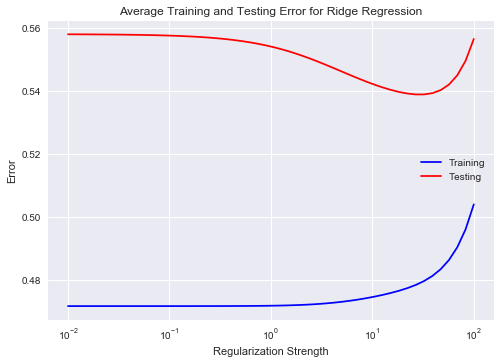

In [57]:
ridge_regression(x_folds, y_folds, 3)

#### 4.2 Discuss the results seen in the plots above

**Discussion**: The ridge regression technique uses a shrinkage penalty to "shrink" (I think a better word would be tamper, but whatever) each coefficient in the linear combination that we use as our prediction. The more shrunken a coefficient is, the smaller the slope, and thus the less "curvy", or flexible, a model is. Therefore, regularization strength is inversely proportional to flexibility, and as we move from left to right on our plot above, the flexibility of our model decreases.

With this in mind, we see that increasing the regularization strength helps to reduce overfitting at all values of alpha (regularization strength) where the training error is decreasing - that is, until the minimum test MSE of 0.5389139340749909 at 𝝰 = 26.82695795, since a more flexible model exists that better fits our test data - this is none other than the model with the next highest regularization strength (until our minimum). After our minimum, less flexible models perform worse on our test data, meaning we are underfitting and that we should use a more flexible model, or equivalently one with a lower regularization strength (leftwards on the graph).